In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf

In [22]:
np.random.seed(7)
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

In [13]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high
    
df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)


In [14]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

# MLP - Ford

In [15]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 733.8193020820618 seconds 
Mean Validation loss= 0.01391054


TypeError: can't convert type 'ndarray' to numerator/denominator

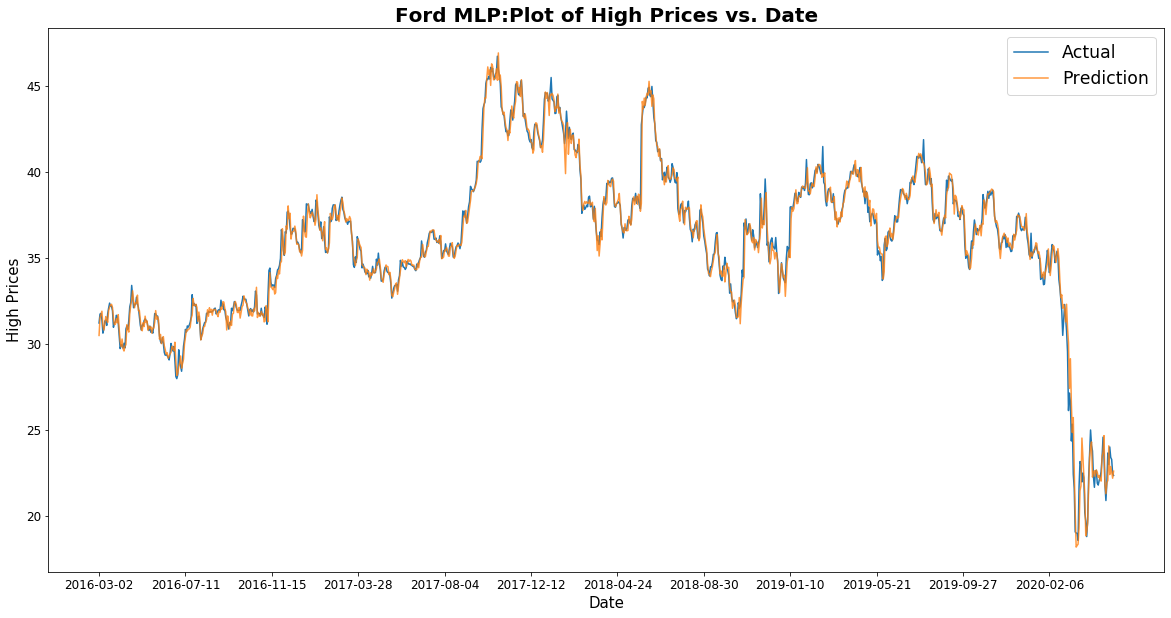

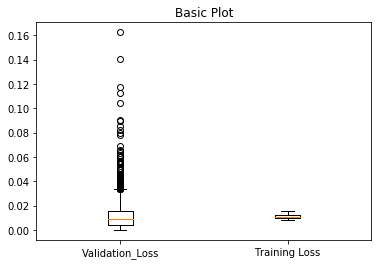

In [16]:
import time
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((6,),input_shape=(6,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('GM MLP:Plot of High Prices vs. Date',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    print('Mean Validation loss=', round(mean(np.array(loss)),8)) 
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 2. Dow Jones Index:

In [17]:
#Convert Date Format:
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

#merge values:
gm_dates = list(gm.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(gm_dates))
gm["dow"] = mean_dow
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    #print(date)
    if date in dow_dates:
        gm["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
gm

198.285659767141 1259


,Open,High,Low,Close,Adj Close,Volume,dow
Date,,,,,,,
2015-05-15,0.620900,0.582270,0.648933,0.610175,0.440398,0.120612,209.91
2015-05-18,0.630030,0.590426,0.653711,0.614892,0.444842,0.129499,212.63
2015-05-19,0.636794,0.591489,0.657216,0.617251,0.447065,0.121978,213.62
2015-05-20,0.639161,0.593617,0.647658,0.613881,0.443890,0.175782,213.01
2015-05-21,0.631045,0.606383,0.658490,0.632749,0.461669,0.229963,211.42
...,...,...,...,...,...,...,...
2020-05-08,0.227596,0.192908,0.277795,0.240229,0.283463,0.239541,237.39
2020-05-11,0.233683,0.171277,0.263141,0.202156,0.238539,0.242902,244.15
2020-05-12,0.224890,0.167021,0.261867,0.194070,0.228997,0.162761,244.85


In [18]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_dow = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_dow.fit(np.array(data['dow']).reshape(-1, 1))
    data['dow'] =scaler_dow.transform(np.array(data['dow']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

In [19]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 727.9407780170441 seconds 
Mean Validation loss= 0.01410459


TypeError: can't convert type 'ndarray' to numerator/denominator

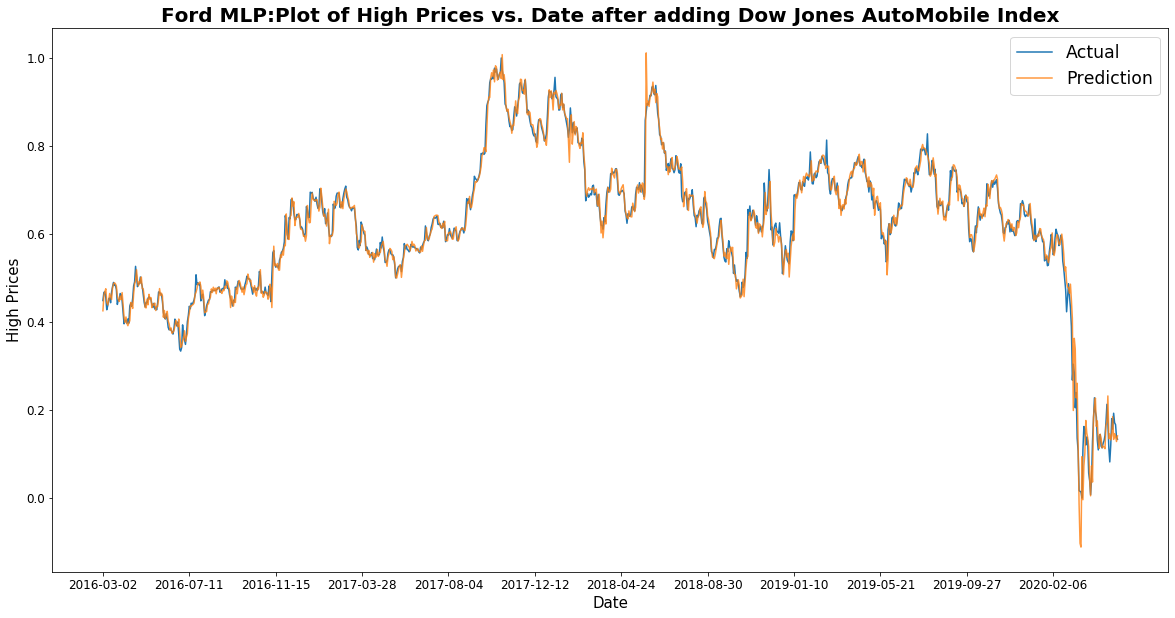

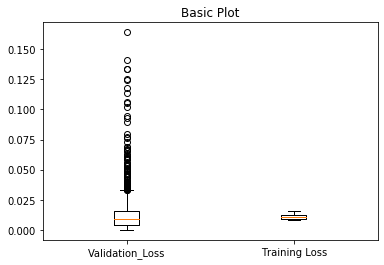

In [20]:
import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('GM MLP:Plot of High Prices vs. Date after adding Dow Jones AutoMobile Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 3. FTSE Opening Index

In [24]:
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    #print(year+'-'+month+'-'+day)
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)
ftse

#merge values:
gm_dates = list(gm.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
print(mean_ftse,len(gm_dates))
gm["ftse"] = mean_ftse
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    #print(date)
    if date in ftse_dates:
        gm["ftse"][row_num] = mean((ftse['newOpen'][ftse['FormatDate']==date]))
    
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6982.075098814229 1259


,Open,High,Low,Close,Adj Close,Volume,ftse
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,6973.000000
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,6960.000000
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,6968.000000
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,6995.000000
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,7007.000000
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,6982.075099
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,5936.000000
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,5939.000000


In [25]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 720.9285399913788 seconds 
Mean Validation loss= 0.01417809


<BarContainer object of 37 artists>

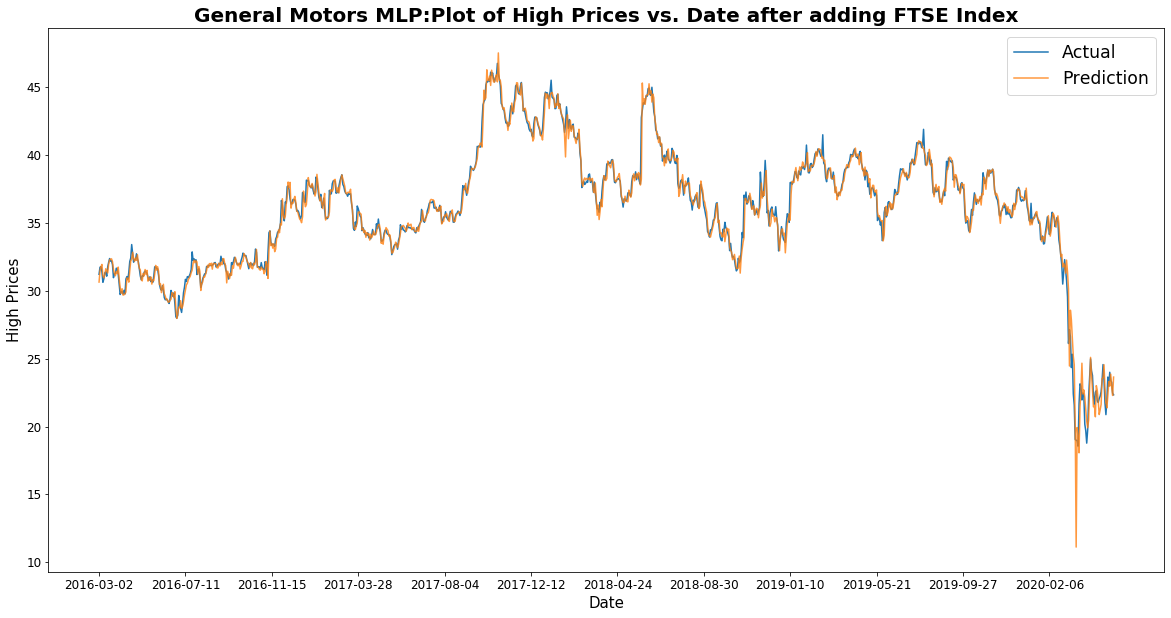

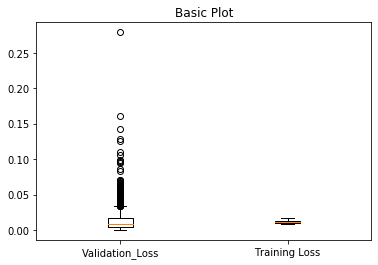

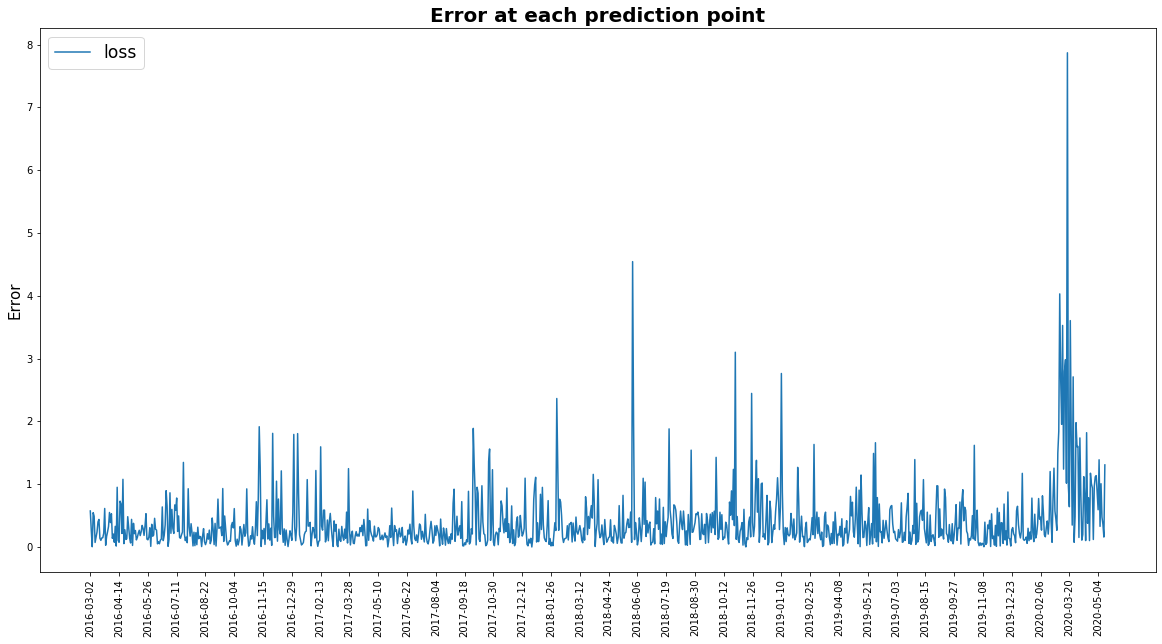

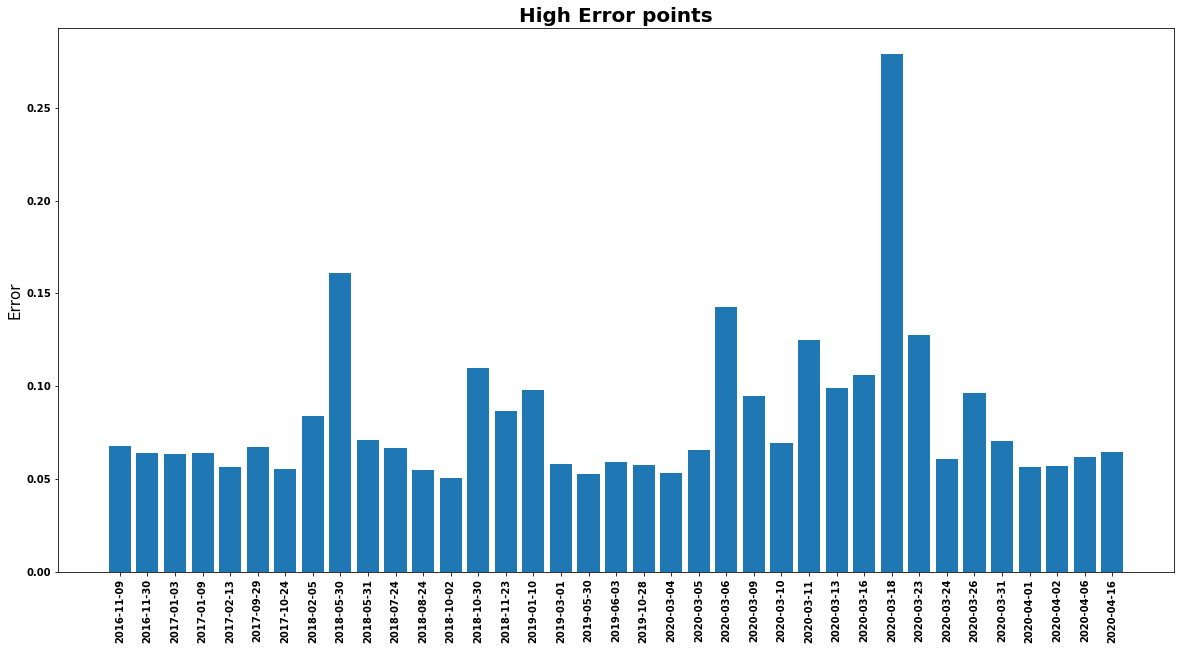

In [26]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding FTSE Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 4. S&P Global Oil Index:

In [29]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)
glb_oil 

#merge values:
gm_dates = list(gm.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
gm["oil"] = mean_oil
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in oil_dates:
        gm["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,oil
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,1956.93
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,1948.25
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,1917.52
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,1916.57
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,1936.78
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,1082.50
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,1071.49
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,1062.24


In [31]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 734.7119238376617 seconds 
Mean Validation loss= 0.01399429


<BarContainer object of 37 artists>

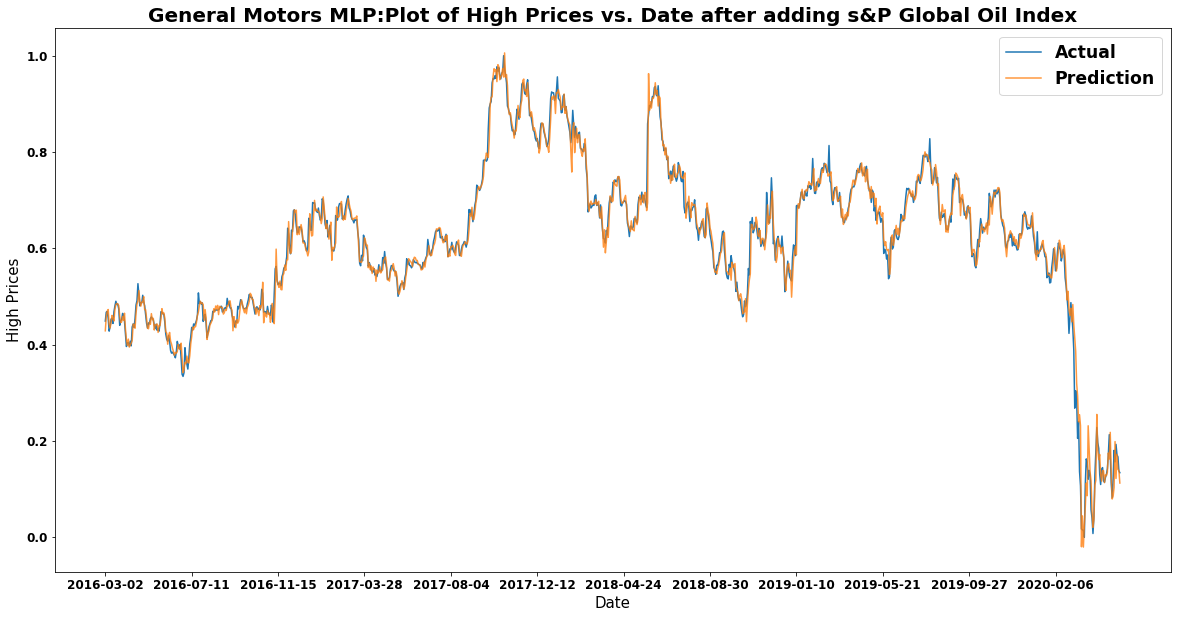

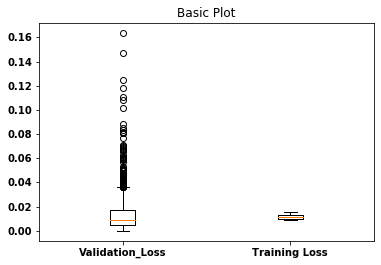

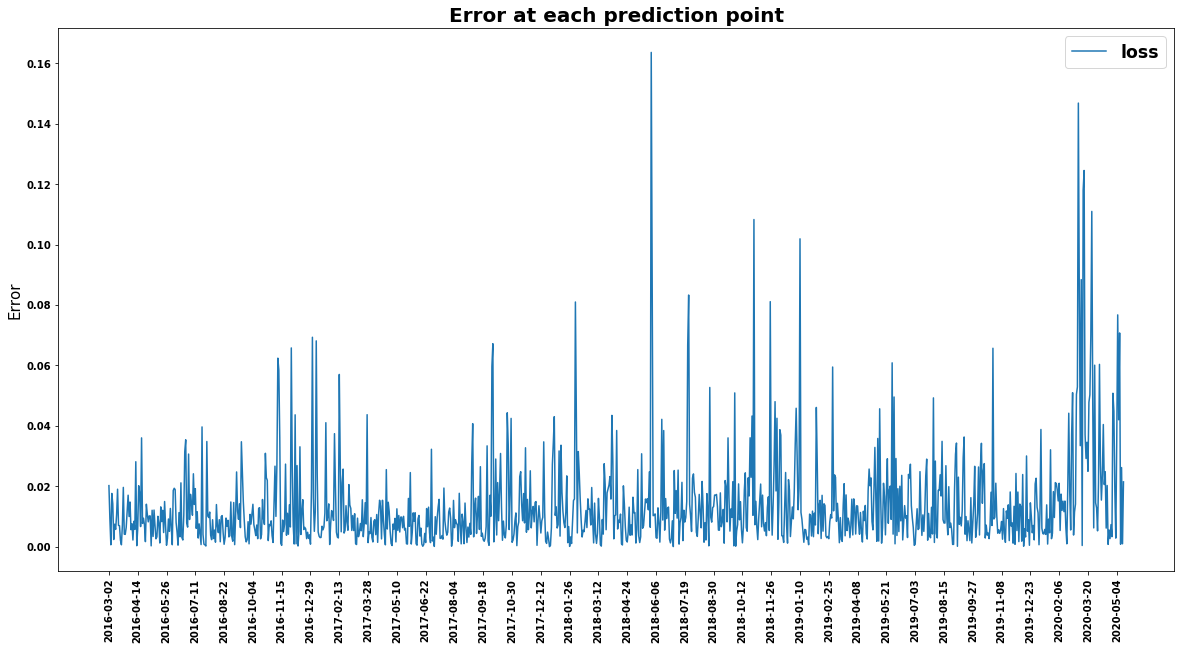

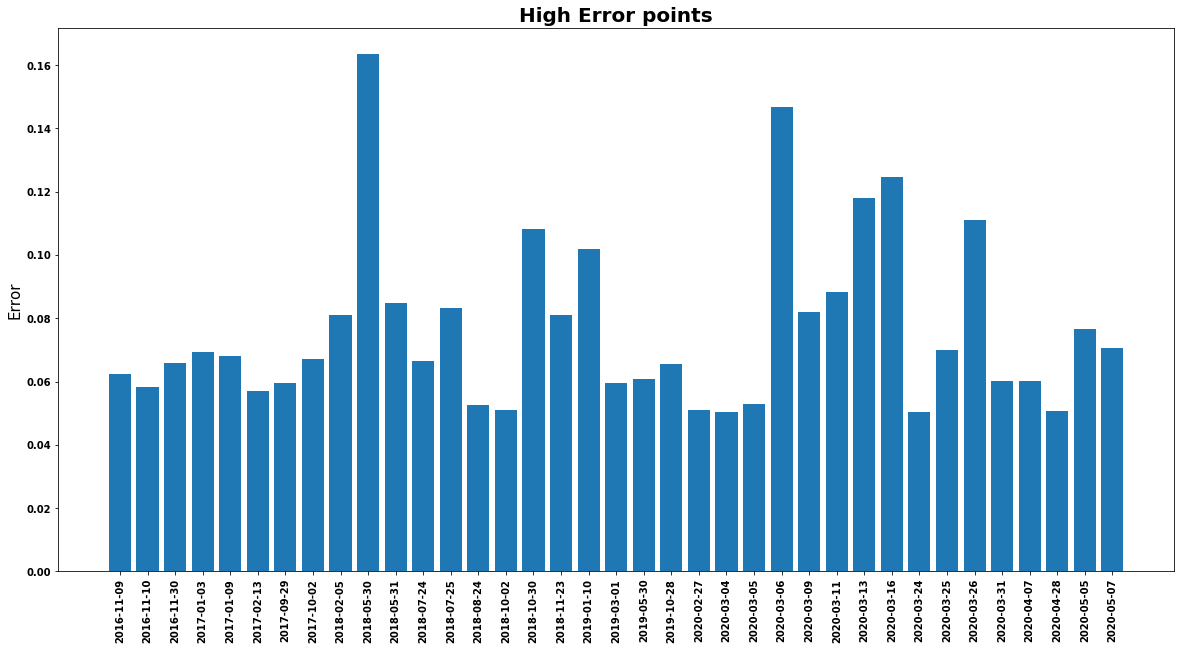

In [32]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding s&P Global Oil Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 5. S&P1000 Index:

In [35]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
gm["S&P1000"] = mean_sp
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in sp1000_dates:
        gm["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,S&P1000
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,8627.79
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,8701.63
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,8689.52
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,8692.93
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,8697.50
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,9409.29
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,9309.29
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,8976.31


In [36]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 717.564934015274 seconds 
Mean Validation loss= 0.01428649


<BarContainer object of 36 artists>

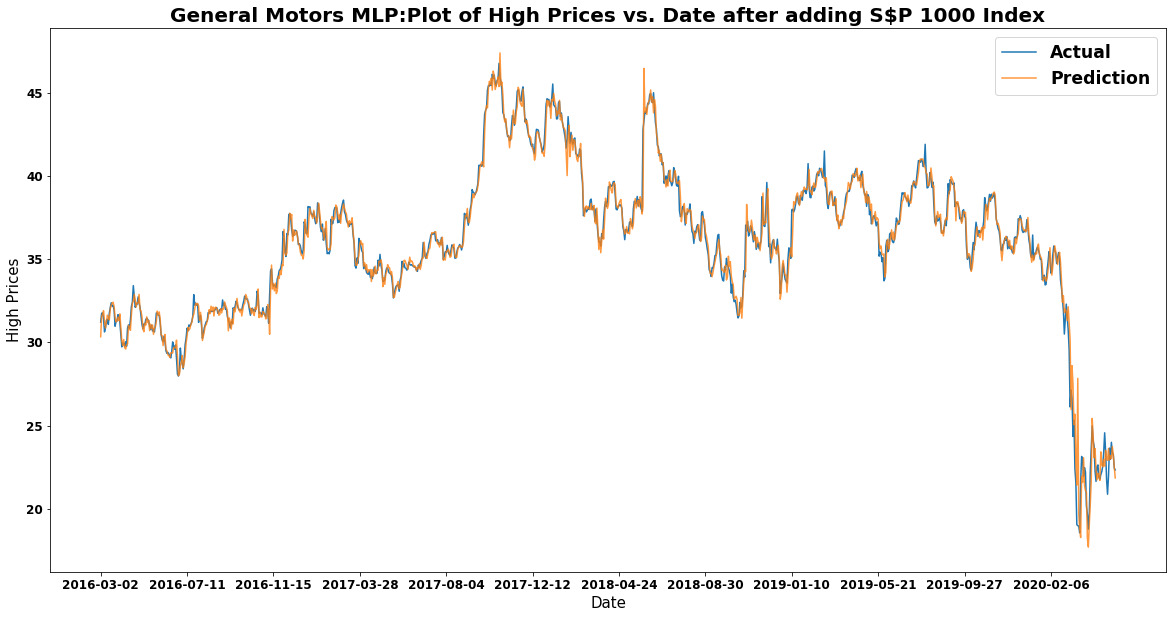

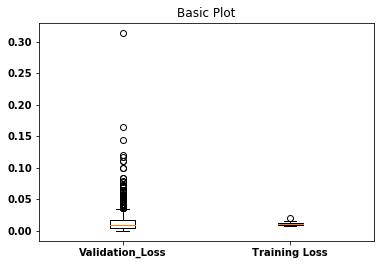

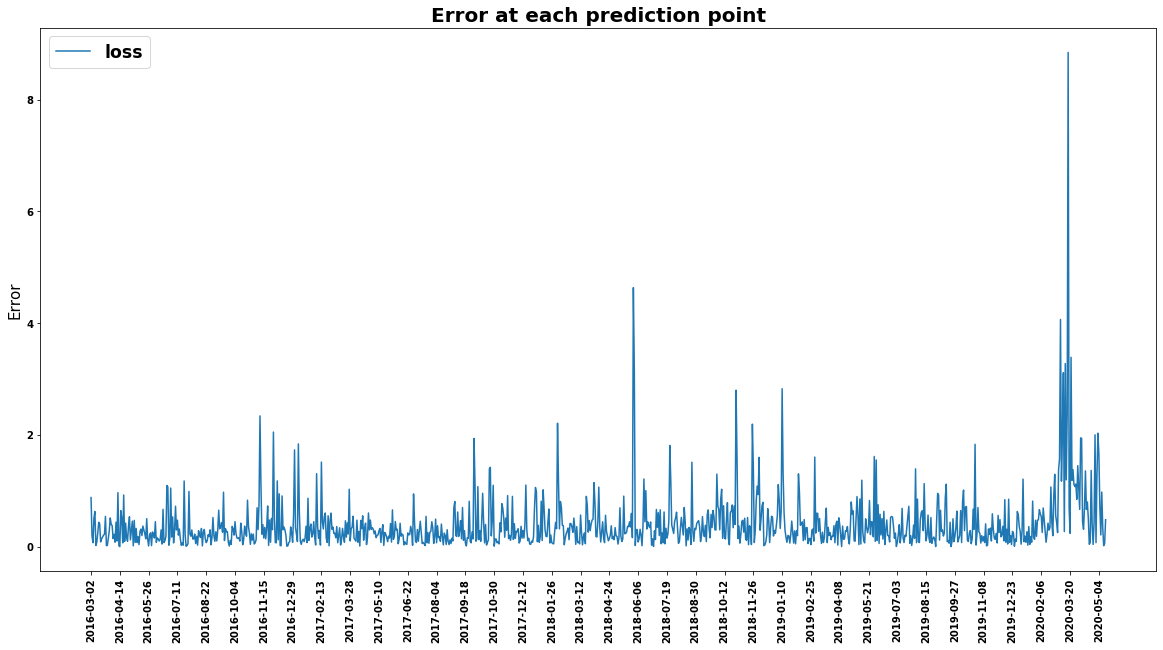

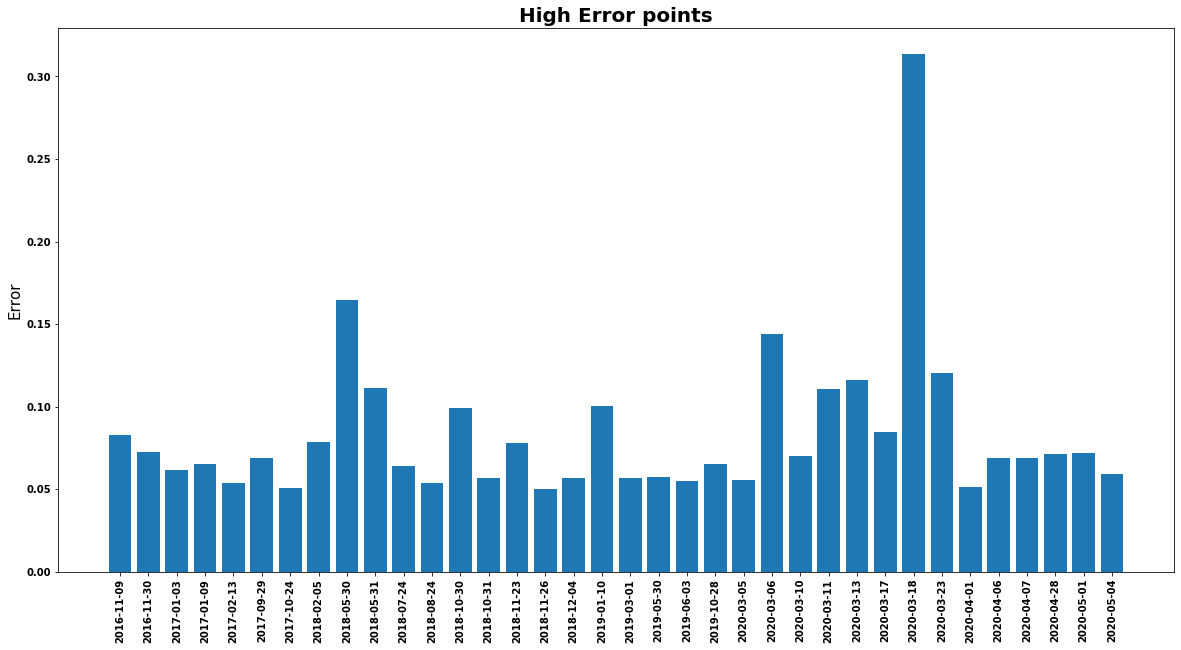

In [37]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding S$P 1000 Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 6. Crude Oil Prices

In [39]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
gm["CrudeOil"] = mean_cop
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in cr_oil_dates:
        gm["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))
    
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,CrudeOil
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,59.69
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,59.43
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,57.26
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,58.98
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,60.72
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,24.74
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,24.14
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,25.78


In [40]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 727.4056079387665 seconds 
Mean Validation loss= 0.01394895


<BarContainer object of 38 artists>

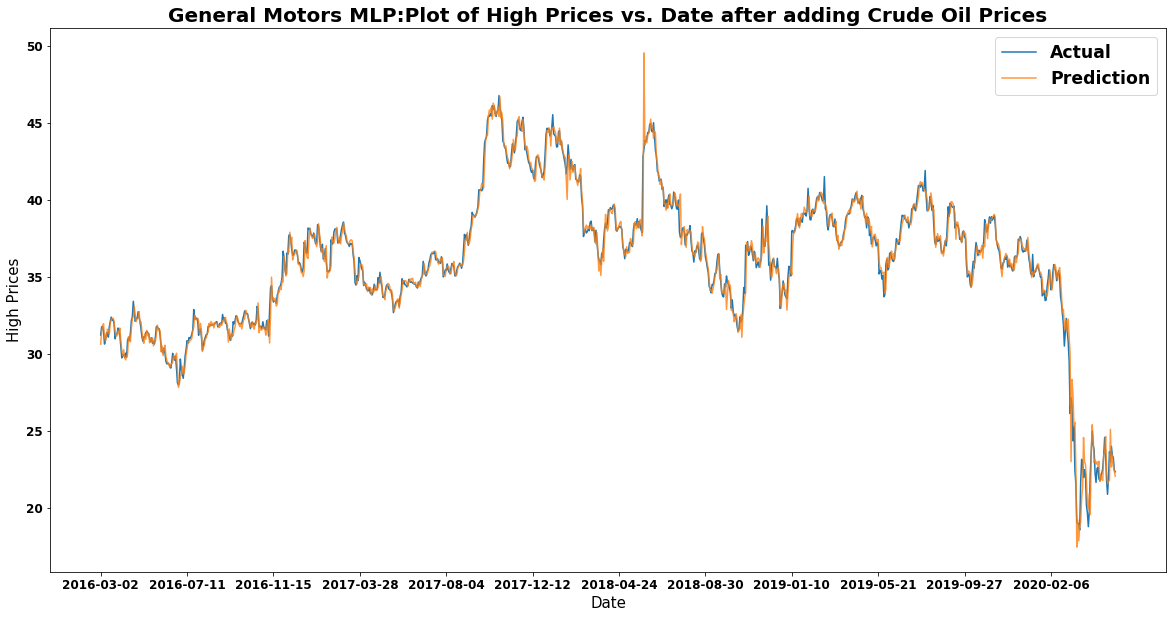

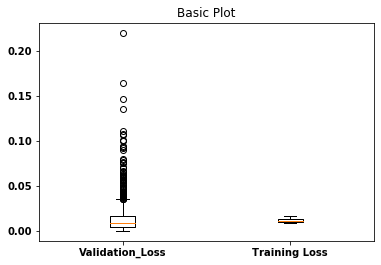

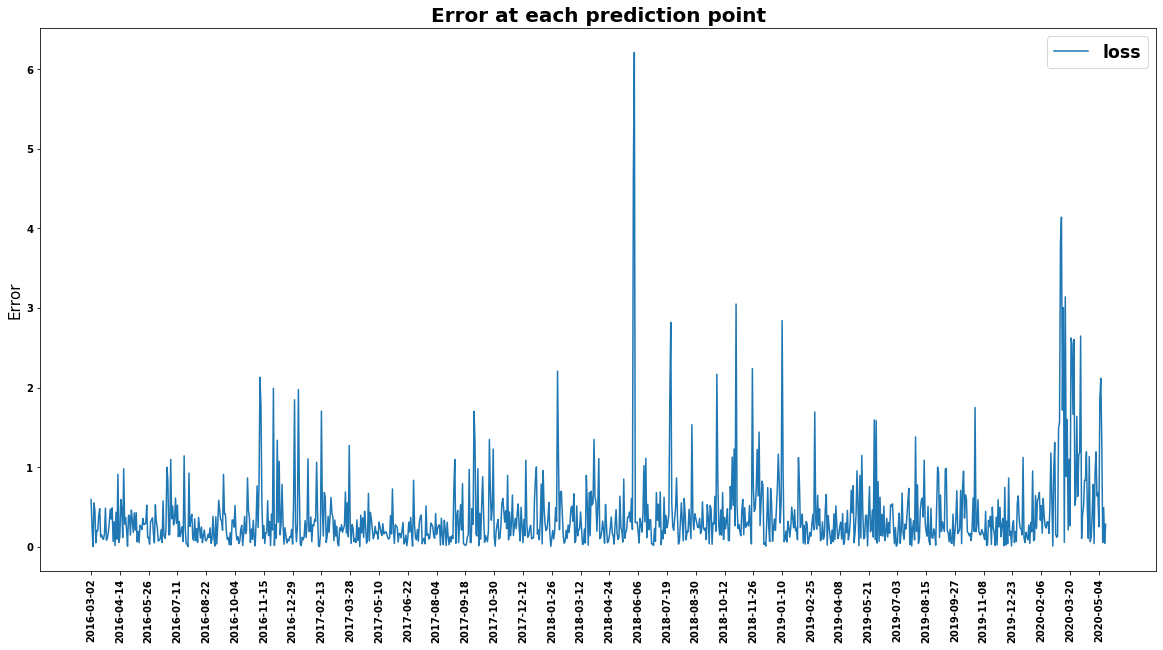

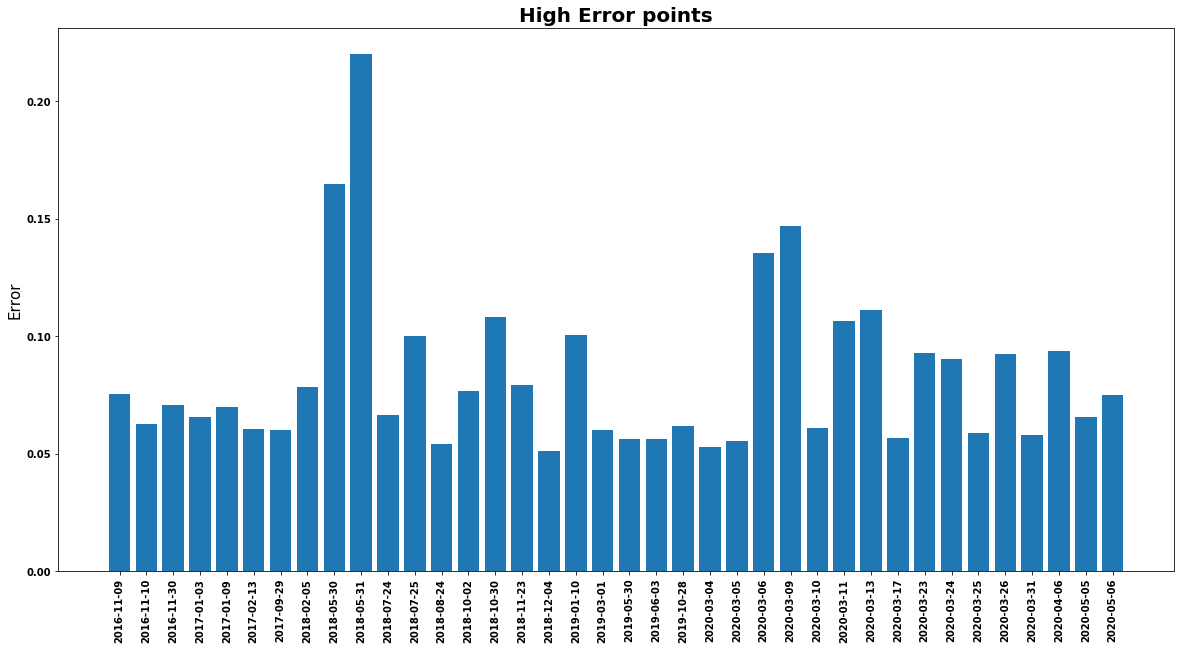

In [41]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding Crude Oil Prices',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 7. Dow Jones Oil & Gas Supersector Titans Index

In [42]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)

#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
gm["TitanOil"] = mean_top
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in titan_oil_dates:
        gm["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,TitanOil
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,445.40
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,443.20
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,437.01
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,437.22
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,441.62
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,267.26
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,265.18
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,262.17


In [43]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 730.5570931434631 seconds 
Mean Validation loss= 0.01414295


<BarContainer object of 33 artists>

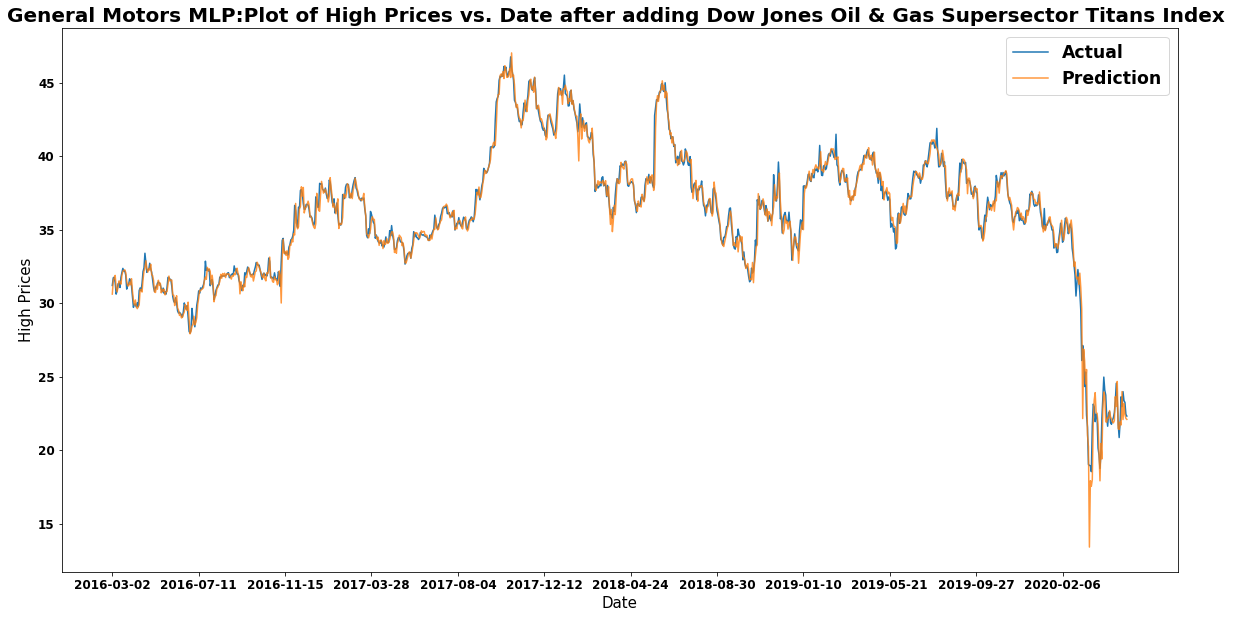

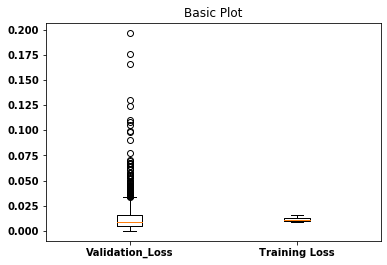

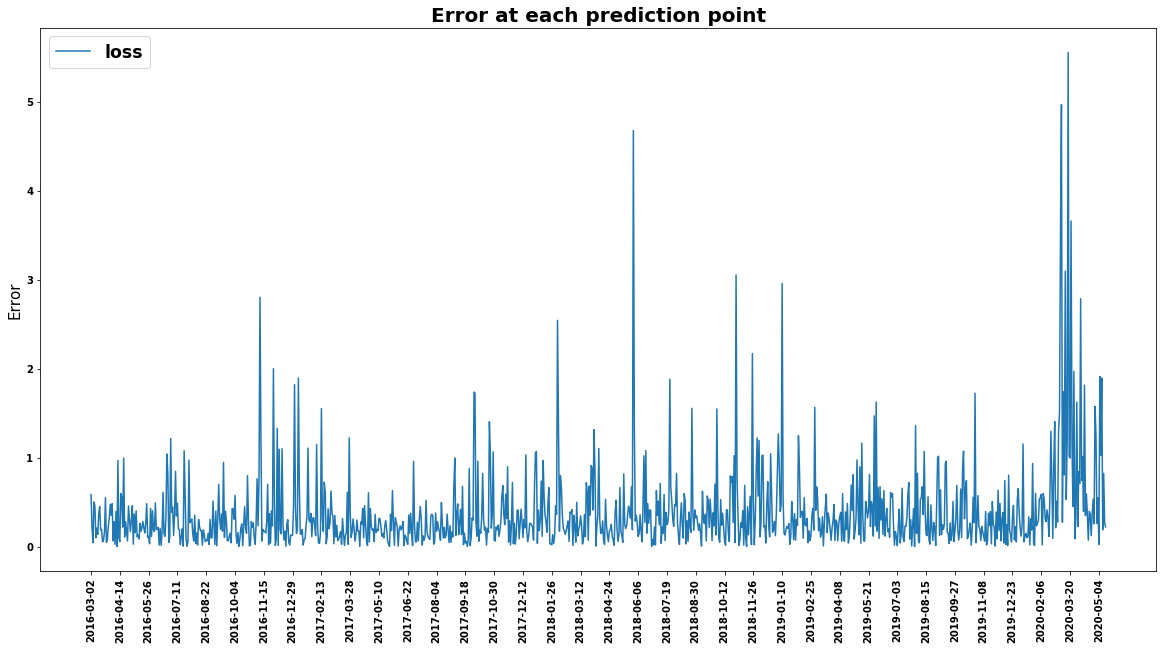

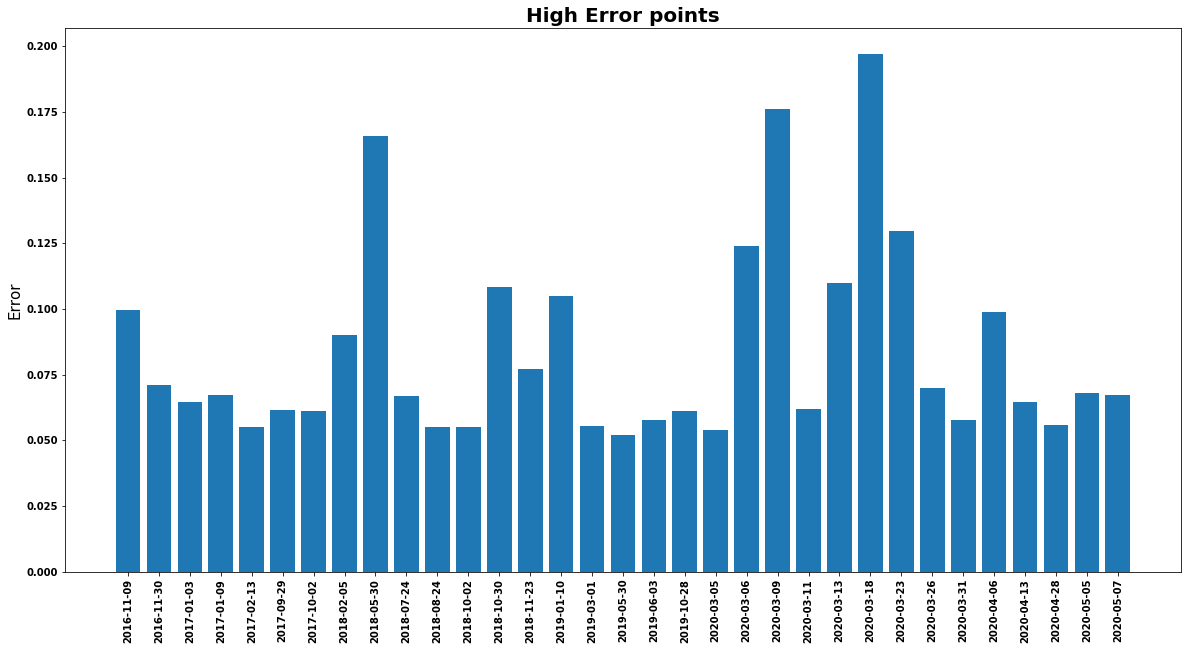

In [45]:

%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding Dow Jones Oil & Gas Supersector Titans Index ',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 8. Car Sales data:

In [59]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
gm_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/GMSales.csv', header=0, index_col=None)
gm_sales

#merge values:
gm_dates = list(gm.index)
sales_dates = list(gm_sales['Month'])
gm["sales"] = 0

for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num][0:7] 
    #print(date,gm_dates[row_num][0:7] )
    #print(date,gm_sales['Sales'][gm_sales['Month']==date])
    gm["sales"][row_num] = gm_sales['Sales'][gm_sales['Month']==date]
        
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Adj Close,Volume,sales
Date,,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,27.877396,9778800,292053
2015-05-18,34.970001,35.209999,34.849998,35.049999,27.989191,10285700,292053
2015-05-19,35.169998,35.240002,34.959999,35.119999,28.045097,9856700,292053
2015-05-20,35.240002,35.299999,34.660000,35.020000,27.965237,12925600,292053
2015-05-21,35.000000,35.660000,35.000000,35.580002,28.412426,16016000,292053
...,...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,23.930000,16562300,196377
2020-05-11,23.250000,23.389999,22.590000,22.799999,22.799999,16754000,196377
2020-05-12,22.990000,23.270000,22.549999,22.559999,22.559999,12182900,196377


In [62]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sales = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_sales.fit(np.array(data['sales']).reshape(-1, 1))
    data['sales'] =scaler_sales.transform(np.array(data['sales']).reshape(-1, 1))
    
    return data,scaler_high

df = gm
dataframe_gm = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values
yarr = np.delete(yarr, 0)

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 736.6674561500549 seconds 
Mean Validation loss= 0.01441427


<BarContainer object of 35 artists>

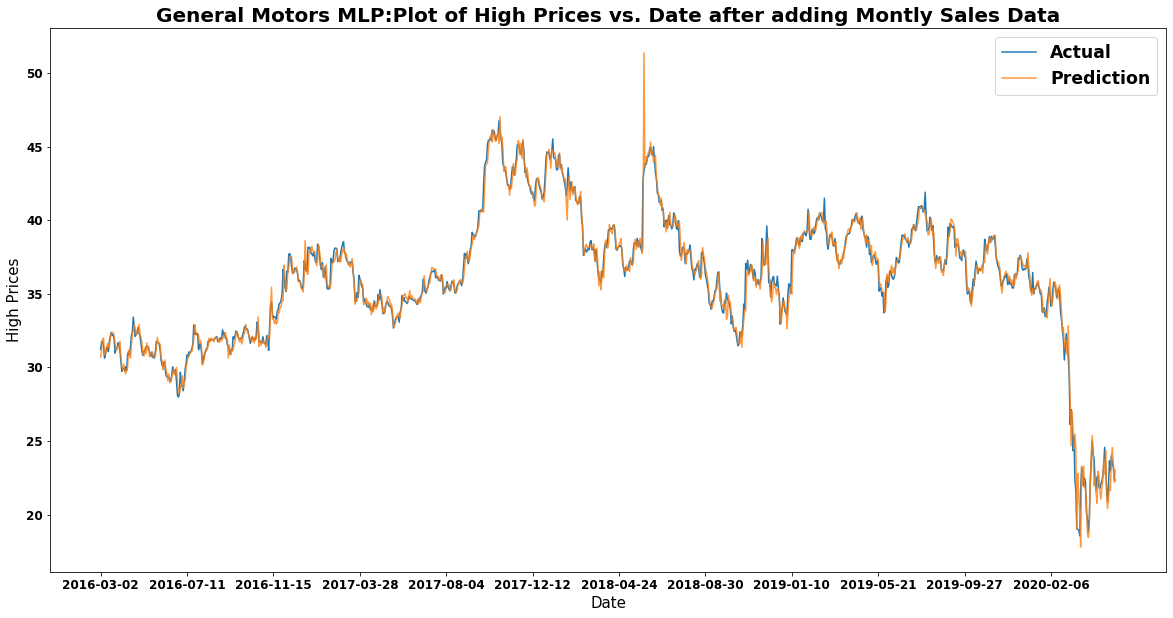

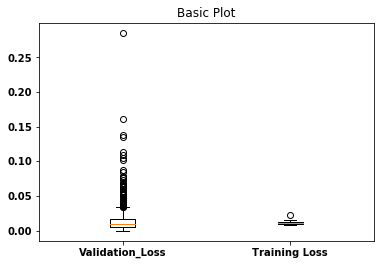

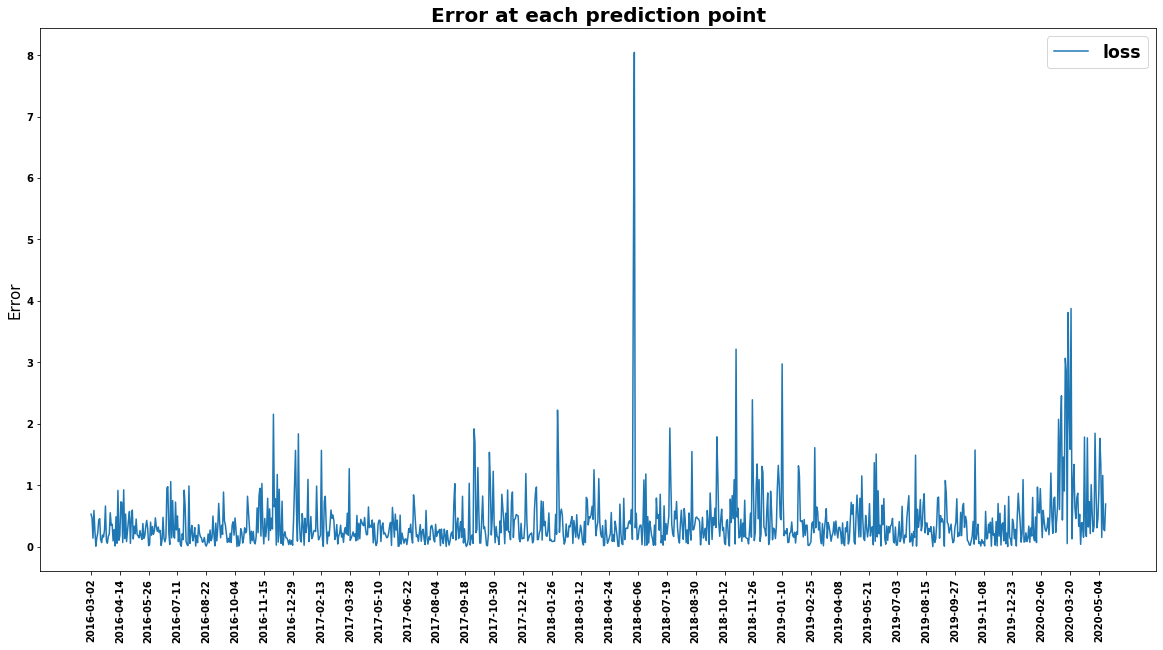

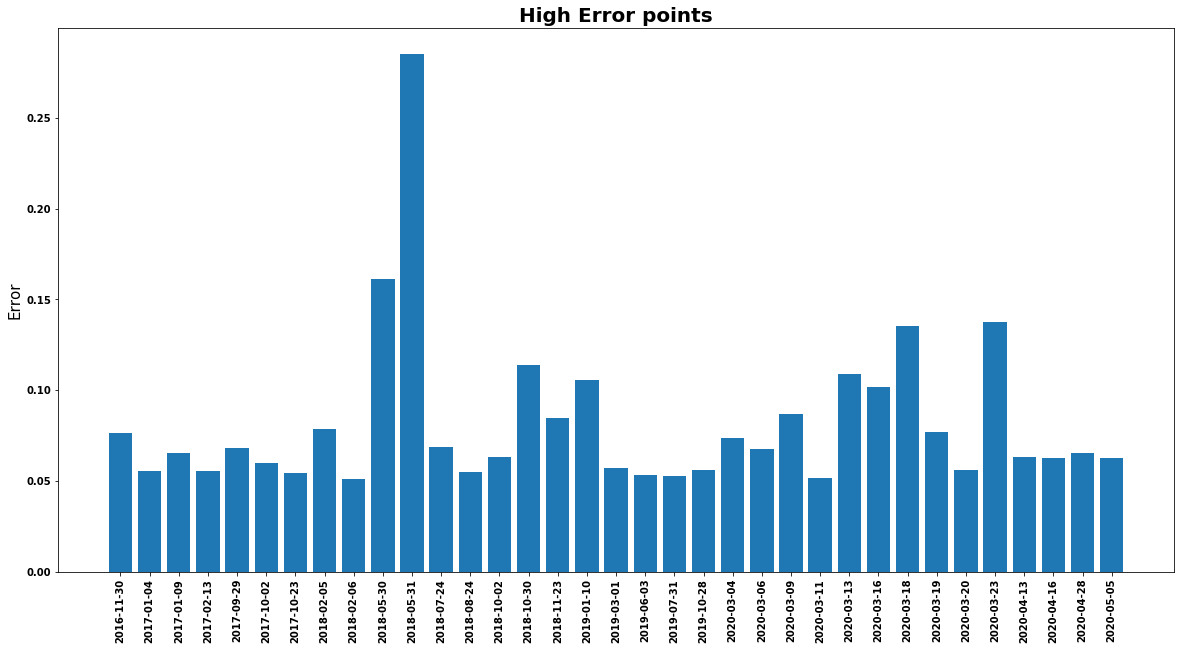

In [64]:
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss="mean_absolute_error",metrics=['accuracy'])

import time
from itertools import chain
start_time = time.time()

window = 200
val_loss = []

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

        
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('General Motors MLP:Plot of High Prices vs. Date after adding Montly Sales Data',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Basic Plot')
    data = [model_val_loss,model_loss]
    ax1.boxplot(data,labels = ['Validation_Loss','Training Loss'])

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

def mae(y_predicted,y_actual,dates):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title('Error at each prediction point',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

mae(predicted,actual,np.array(predicted_dates))

large_loss = []
large_loss_date = []
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High Error points',fontsize=20,fontweight='bold')
plt.ylabel('Error',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)


# 9. Final Model: